In [1]:
import pandas as pd
from math import cos, radians, sqrt
from sklearn.neighbors import BallTree
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import warnings
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.formula.api as smf
from scipy.stats import skew
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from matplotlib.ticker import PercentFormatter

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)
np.set_printoptions(suppress = True)
np.set_printoptions(precision = 2)

In [3]:
raw = "C:\\Users\\taavi\\Desktop\\BPHIL\\Raw data\\"
clean = "C:\\Users\\taavi\\Desktop\\BPHIL\\Clean data\\"

In [4]:
parcels = pd.read_csv(clean + 'blight.csv')
#parcels = pd.read_csv(clean + 'blight_and_values.csv')

In [5]:
demos = pd.read_csv(clean + 'blight_and_demos.csv')

In [6]:
values = pd.read_csv(clean + 'clean_values.csv')

### Getting 'demos_decayed'

In [13]:
years = range(values['year'].min(), values['year'].max() + 1)

In [ ]:
full = pd.DataFrame()

earthRadius = 6_378_137 # meters

distances = np.arange(50, 800, 50)
distances_radians = distances / earthRadius
weights = [(i + 1) / len(distances) for i, r in enumerate(distances)][::-1]

for year in tqdm(years):
    parcels_sub = parcels.loc[parcels['year'] == year].reset_index(drop = True)
    demos_sub = demos.loc[pd.to_datetime(demos['date'], format = 'mixed').dt.year == year].reset_index(drop = True)

    parcels_coords = np.radians(parcels_sub[['lat', 'lng']].to_numpy())
    demos_coords = np.radians(demos_sub[['lat', 'lng']].to_numpy())

    demo_tree = BallTree(demos_coords, metric = 'haversine')
    
    # count and sum values in each distance bin
    for d_m, d_r in zip(distances, distances_radians):
        indices_within_radius = demo_tree.query_radius(parcels_coords, r = d_r)
        counts = [len(idxs) for idxs in indices_within_radius]
        parcels_sub[f'demos_count_{d_m}'] = counts

    for i, r in enumerate(distances[::-1]):
        if r != distances[0]:
            parcels_sub[f'demos_count_{r}'] -= parcels_sub[f'demos_count_{distances[::-1][i + 1]}']

    parcels_sub['demos_decayed'] = (parcels_sub.iloc[:, -len(distances):] * weights).sum(axis = 1)

        
    full = pd.concat([full, parcels_sub], axis = 0)

full = full.reset_index(drop = True)

In [ ]:
full['demos_decayed'].value_counts(normalize = True)

In [ ]:
full.groupby('year')['demos_decayed'].mean()

In [ ]:
full.groupby(['year', 'blight'])['demos_decayed'].mean()[28:]

### Dataset of demos with values, then assigning blight cluster with a merge on parcelID

In [31]:
demos = demos[['parcelID', 'date', 'lat', 'lng', 'value', 'comm_res']]
demos['year'] = pd.to_datetime(demos['date'], format = 'mixed').dt.year
demos = demos.sort_values(by = ['year', 'parcelID']).reset_index(drop = True)

#### Extending demos temporally

In [32]:
years = pd.date_range(start = values['date'].min(), end = '2025-12-31', freq = 'Y')

In [ ]:
demos = demos.merge(pd.DataFrame({'date': years}), how = 'cross').sort_values(by = 'date').reset_index(drop = True)
demos['date'] = demos['date'].dt.year
demos = demos.rename(columns = {'date': 'year'}).sort_values(by = ['parcelID', 'year']).reset_index(drop = True)

In [73]:
full = pd.DataFrame()

earthRadius = 6_378_137 # meters

distances = np.arange(50, 800, 50)
distances_radians = distances / earthRadius
weights = [(i + 1) / len(distances) for i, r in enumerate(distances)][::-1]

for year in tqdm(years):
    demos_sub = demos.loc[demos['year'] == year.year].reset_index(drop = True)
    values_sub = values.loc[values['year'] == year.year].reset_index(drop = True)

    parcels_coords = np.radians(demos_sub[['lat', 'lng']].to_numpy())
    values_coords = np.radians(values_sub[['lat', 'lng']].to_numpy())

    value_tree = BallTree(values_coords, metric = 'haversine')
    
    # count and sum values in each distance bin
    for d_m, d_r in zip(distances, distances_radians):
        indices_within_radius = value_tree.query_radius(parcels_coords, r = d_r)
        counts = [len(idxs) for idxs in indices_within_radius]
        demos_sub[f'values_count_{d_m}'] = counts

        sums = [values_sub.loc[idxs, 'value'].sum() for idxs in indices_within_radius]
        demos_sub[f'values_sum_{d_m}'] = sums

    demos_sub = demos_sub.fillna(0)

    for i, r in enumerate(distances[::-1]):
        if r != distances[0]:
            demos_sub[f'values_count_{r}'] -= demos_sub[f'values_count_{distances[::-1][i + 1]}']
            demos_sub[f'values_sum_{r}'] -= demos_sub[f'values_sum_{distances[::-1][i + 1]}']
    
    demos_sub['values_count_decayed'] = (demos_sub.iloc[:, -len(distances) * 2::2] * weights).sum(axis = 1)
    demos_sub['values_sum_decayed'] = (demos_sub.iloc[:, -len(distances) * 2::2] * weights).sum(axis = 1)

    demos_sub['values_decayed'] = demos_sub['values_sum_decayed'] / demos_sub['values_count_decayed']

    full = pd.concat([full, demos_sub], axis = 0)

full = full.reset_index(drop = True)

100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


In [74]:
demos = full.copy()

### Smoothing, deltas, and column cleanup

In [75]:
train = demos.loc[(demos['values_decayed'].isna() == False)]
x = train[['lat', 'lng']]
y = train['values_decayed']

knn = KNeighborsRegressor(n_neighbors = 5)
demos.loc[(demos['values_decayed'].isna()) | (demos['values_decayed'] == 0), 'values_decayed'] = knn.fit(x, y).predict(demos.loc[(demos['values_decayed'].isna()) | (demos['values_decayed'] == 0), ['lat', 'lng']])

demos = demos.sort_values(by = ['parcelID', 'year']).reset_index(drop = True)

same_parcel_prev_1 = demos['parcelID'].eq(demos['parcelID'].shift(1))
same_parcel_prev_2 = demos['parcelID'].eq(demos['parcelID'].shift(2))
same_parcel_prev_3 = demos['parcelID'].eq(demos['parcelID'].shift(3))
same_parcel_prev_4 = demos['parcelID'].eq(demos['parcelID'].shift(4))
same_parcel_prev_5 = demos['parcelID'].eq(demos['parcelID'].shift(5))

demos = (
    demos
    .assign(
        past_1 = demos['values_decayed'].shift(1).where(same_parcel_prev_1),
        past_2 = demos['values_decayed'].shift(2).where(same_parcel_prev_2),
        past_3 = demos['values_decayed'].shift(3).where(same_parcel_prev_3),
        past_4 = demos['values_decayed'].shift(4).where(same_parcel_prev_4),
        past_5 = demos['values_decayed'].shift(5).where(same_parcel_prev_5),
    )
    .assign(
        values_smoothed = lambda x: pd.concat([x['values_decayed'], x['past_1'], x['past_2'], x['past_3'], x['past_4'], x['past_5']], axis = 1).mean(axis = 1)
    )
    .assign(
        nom_delta_1 = lambda x: x['values_smoothed'].diff(1).where(same_parcel_prev_1).shift(-1),
        nom_delta_2 = lambda x: x['values_smoothed'].diff(2).where(same_parcel_prev_2).shift(-2),
        nom_delta_3 = lambda x: x['values_smoothed'].diff(3).where(same_parcel_prev_3).shift(-3),
        nom_delta_4 = lambda x: x['values_smoothed'].diff(4).where(same_parcel_prev_4).shift(-4),
        nom_delta_5 = lambda x: x['values_smoothed'].diff(5).where(same_parcel_prev_5).shift(-5),
        pct_delta_1 = lambda x: x['values_smoothed'].pct_change(1).where(same_parcel_prev_1).shift(-1),
        pct_delta_2 = lambda x: x['values_smoothed'].pct_change(2).where(same_parcel_prev_2).shift(-2),
        pct_delta_3 = lambda x: x['values_smoothed'].pct_change(3).where(same_parcel_prev_3).shift(-3),
        pct_delta_4 = lambda x: x['values_smoothed'].pct_change(4).where(same_parcel_prev_4).shift(-4),
        pct_delta_5 = lambda x: x['values_smoothed'].pct_change(5).where(same_parcel_prev_5).shift(-5),
    )
    .assign(
        cagr_1 = lambda x: ((x['pct_delta_1'] + 1) ** (1/1)) - 1,
        cagr_2 = lambda x: ((x['pct_delta_2'] + 1) ** (1/2)) - 1,
        cagr_3 = lambda x: ((x['pct_delta_3'] + 1) ** (1/3)) - 1,
        cagr_4 = lambda x: ((x['pct_delta_4'] + 1) ** (1/4)) - 1,
        cagr_5 = lambda x: ((x['pct_delta_5'] + 1) ** (1/5)) - 1
    )
    .reset_index(drop = True)
    [['parcelID', 'lat', 'lng', 'demo_year', 'year', 'values_smoothed', 'nom_delta_1', 'nom_delta_2', 'nom_delta_3', 'nom_delta_4', 'nom_delta_5',
      'pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5', 'cagr_1', 'cagr_2', 'cagr_3', 'cagr_4', 'cagr_5']]
)

In [76]:
print('MEAN')
print(demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].mean())
print('STDEV')
print(demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].std())
print('\n')
print('MEDIAN')
print(demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].median())
print('IQR')
print(demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].quantile(0.75) -
      demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].quantile(0.25))

MEAN
pct_delta_1   0.13
pct_delta_2   0.23
pct_delta_3   0.40
pct_delta_4   0.53
pct_delta_5   0.68
dtype: float64
STDEV
pct_delta_1   0.40
pct_delta_2   0.49
pct_delta_3   1.01
pct_delta_4   0.99
pct_delta_5   1.16
dtype: float64


MEDIAN
pct_delta_1   0.05
pct_delta_2   0.12
pct_delta_3   0.20
pct_delta_4   0.30
pct_delta_5   0.41
dtype: float64
IQR
pct_delta_1   0.13
pct_delta_2   0.26
pct_delta_3   0.41
pct_delta_4   0.57
pct_delta_5   0.73
dtype: float64


### Merging blight from parcels

In [7]:
demos = demos.merge(right = parcels[['parcelID', 'nbrhd', 'blight', 'blight_sqrt']].drop_duplicates(subset = 'parcelID'), on = 'parcelID', how = 'inner')

In [78]:
demos.to_csv(clean + 'demos_values_blight.csv', index = False)

In [44]:
demos = pd.read_csv(clean + 'demos_values_blight.csv')

### Investigating the relationship between demos and values, given underlying levels of blight

In [79]:
demos_testing = demos.loc[demos['demo_year'] == demos['year']]

In [80]:
model = smf.ols(formula = 'values_smoothed ~ C(blight_sqrt)', data = demos_testing).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        values_smoothed   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     65.83
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           1.70e-68
Time:                        09:52:16   Log-Likelihood:                -12855.
No. Observations:                 961   AIC:                         2.572e+04
Df Residuals:                     954   BIC:                         2.576e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             1.92e+05   2

In [39]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)

In [ ]:
# parcels = parcels.loc[parcels['year'] >= 2020]

In [ ]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)
parcels['value_mean'] = parcels.groupby('parcelID')['values_smoothed'].transform('mean')
demos = demos.loc[demos['demo_year'] == demos['year']]
demos['blight_sqrt'] = demos['blight_sqrt'].astype(str)
parcels = parcels.drop_duplicates(subset = 'parcelID')
exposure = pd.read_csv(clean + 'parcels_demo_exposure.csv')

In [46]:
exposure = pd.read_csv(clean + 'parcels_demo_exposure.csv')

In [52]:
# demo_ids = demos['parcelID'].unique()
high_exposure_ids = exposure.loc[exposure['high_exposure'] == 1]['parcelID'].unique()
# pop_control = parcels.loc[~parcels['parcelID'].isin(demo_ids)]
pop_control = parcels.loc[~parcels['parcelID'].isin(high_exposure_ids)]
high_exposure_subset = parcels.loc[parcels['parcelID'].isin(high_exposure_ids)]

In [55]:
# demo_ids = demos['parcelID'].unique()
high_exposure_ids = exposure.loc[exposure['high_exposure'] == 1]['parcelID'].unique()
# pop_control = parcels.loc[~parcels['parcelID'].isin(demo_ids)]
pop_control = parcels.loc[~parcels['parcelID'].isin(high_exposure_ids)]
high_exposure_subset = parcels.loc[parcels['parcelID'].isin(high_exposure_ids)]

# Step 2: create a list to hold results
results = []

# Step 3: loop over each blight cluster
for c in sorted(parcels['blight_sqrt'].unique()):
    demo_vals = high_exposure_subset.loc[high_exposure_subset['blight_sqrt'] == c, 'values_smoothed']
    control_vals = pop_control.loc[pop_control['blight_sqrt'] == c, 'value_mean']
    
    n_demo = len(demo_vals)
    n_control = len(control_vals)
    
    if n_demo == 0 or n_control == 0:
        continue
    
    # Mann-Whitney U test
    stat, p_val = mannwhitneyu(demo_vals, control_vals, alternative='two-sided')
    
    # Median values
    median_demo = demo_vals.median()
    median_control = control_vals.median()
    
    # Median difference (demo - control)
    median_diff = median_demo - median_control
    
    # Optional: rank-biserial effect size
    effect_size = 1 - (2 * stat / (n_demo * n_control))
    
    results.append({
        'Blight': c,
        'n_demo': n_demo,
        'n_control': n_control,
        'Median_demo': median_demo,
        'Median_control': median_control,
        'Median_diff': median_diff,
        'U_stat': stat,
        'p_value': p_val,
        'Effect_size': effect_size
    })

# Step 4: convert to DataFrame
summary_table = pd.DataFrame(results)

# Step 5: display
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
summary_table[['Blight', 'n_demo', 'n_control', 'Median_demo', 'Median_control', 'p_value']]

,Blight,n_demo,n_control,Median_demo,Median_control,p_value
0,5,1583,30206,"27,587.23","108,446.56",0.00
1,6,3793,8358,"29,066.43","209,947.27",0.00


In [ ]:
demo_vals.shape

In [ ]:
sns.kdeplot(parcels['value_mean'])
plt.show()

In [ ]:
skew(parcels['value_mean'])

In [ ]:
sns.kdeplot(demos['values_smoothed'])
plt.show()

In [ ]:
skew(demos['values_smoothed'])

In [ ]:
parcels['value_mean'].std() ** 2, demos['values_smoothed'].std() ** 2

In [ ]:
for c in demos.sort_values(by = 'blight_sqrt')['blight_sqrt'].unique():
    sub = parcels.loc[parcels['blight_sqrt'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(round(sub['value_mean'].median(), 1))
    print('n:', n)
    print('\n')

In [ ]:
for c in demos.sort_values(by = 'blight_sqrt')['blight_sqrt'].unique():
    sub = demos.loc[demos['blight_sqrt'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(round(sub['values_smoothed'].median(), 1))
    print('n:', n)
    print('\n')

In [ ]:
for c in demos['blight_sqrt'].unique():
    sub = parcels.loc[parcels['blight_sqrt'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(sub[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].median())
    print('n:', n)
    print('\n')

In [ ]:
for c in demos['blight_sqrt'].unique():
    sample = demos.loc[demos['demo_year'] == demos['year']]
    sub = sample.loc[sample['blight_sqrt'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(sub[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].median())
    print('n:', n)
    print('\n')

In [15]:
parcels

,parcelID,lat,lng,year,blight,blight_sqrt,viols_count_decayed,low_count_decayed,high_count_decayed,values_decayed,values_smoothed,viols_sqrt,low_sqrt,high_sqrt,nom_delta_1,nom_delta_2,nom_delta_3,nom_delta_4,nom_delta_5,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5,cagr_1,cagr_2,cagr_3,cagr_4,cagr_5,nbrhd
0,0001A00100000000,40.44,-80.01,2016,1,2,25.67,62.36,46.21,"388,872.38","388,872.38",5.07,7.90,6.80,"-30,159.59","-27,708.77","-18,425.53","3,479.45","16,152.17",-0.08,-0.07,-0.05,0.01,0.04,-0.08,-0.04,-0.02,0.00,0.01,Central Business District
1,0001A00100000000,40.44,-80.01,2017,1,2,25.67,62.36,46.21,"328,553.19","358,712.78",5.07,7.90,6.80,"2,450.82","11,734.07","33,639.05","46,311.77","31,802.30",0.01,0.03,0.09,0.13,0.09,0.01,0.02,0.03,0.03,0.02,Central Business District
2,0001A00100000000,40.44,-80.01,2018,1,2,25.67,62.36,46.21,"366,065.24","361,163.60",5.07,7.90,6.80,"9,283.25","31,188.23","43,860.95","29,351.48","53,480.91",0.03,0.09,0.12,0.08,0.15,0.03,0.04,0.04,0.02,0.03,Central Business District
3,0001A00100000000,40.44,-80.01,2019,1,2,25.67,62.36,46.21,"398,296.59","370,446.85",5.07,7.90,6.80,"21,904.98","34,577.70","20,068.23","44,197.67","56,038.18",0.06,0.09,0.05,0.12,0.15,0.06,0.05,0.02,0.03,0.03,Central Business District
4,0001A00100000000,40.44,-80.01,2020,1,2,25.67,62.36,46.21,"479,971.75","392,351.83",5.07,7.90,6.80,"12,672.72","-1,836.75","22,292.69","34,133.20","6,246.22",0.03,-0.00,0.06,0.09,0.02,0.03,-0.00,0.02,0.02,0.00,Central Business District
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440305,8120X00002000000,40.43,-80.07,2021,1,1,51.93,4.98,1.57,"127,403.01","93,186.58",7.21,2.23,1.25,"9,529.22","17,540.83","15,803.62","27,110.85",NaN,0.10,0.19,0.17,0.29,NaN,0.10,0.09,0.05,0.07,NaN,Oakwood
1440306,8120X00002000000,40.43,-80.07,2022,1,1,51.93,4.98,1.57,"117,586.84","102,715.80",7.21,2.23,1.25,"8,011.61","6,274.40","17,581.63",NaN,NaN,0.08,0.06,0.17,NaN,NaN,0.08,0.03,0.05,NaN,NaN,Oakwood
1440307,8120X00002000000,40.43,-80.07,2023,1,1,51.93,4.98,1.57,"144,537.74","110,727.40",7.21,2.23,1.25,"-1,737.21","9,570.03",NaN,NaN,NaN,-0.02,0.09,NaN,NaN,NaN,-0.02,0.04,NaN,NaN,NaN,Oakwood
1440308,8120X00002000000,40.43,-80.07,2024,1,1,51.93,4.98,1.57,"66,022.60","108,990.20",7.21,2.23,1.25,"11,307.23",NaN,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,Oakwood


In [ ]:
fig = px.scatter_mapbox(demos, lat = 'lat', lon = 'lng', color = 'Blight', color_discrete_map = color_discrete_map, zoom = 10,
                        category_orders = {'Blight': ['1', '2', '3', '4', '5', '6', '7', 'Demo']}, hover_data = ['Neighborhood'])
fig.update_layout(mapbox_style = 'carto-positron')
fig.show()

In [80]:
exposure.groupby('high_exposure')['blight_sqrt'].value_counts()

high_exposure  blight_sqrt
0              3              39123
               2              34215
               5              30206
               1              14755
               4              11044
               6               8358
               7                954
1              6               3793
               5               1583
Name: count, dtype: int64

In [25]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')
demos = pd.read_csv(clean + 'blight_and_demos.csv')

In [ ]:
(
    parcels
    .merge(
        right = (
            demos
            .assign(high_exposure_year = np.where(demos['high_exposure'] == 1, demos['year'], 0))
            .assign(high_exposure_year = lambda x: x.groupby('parcelID'))
        )
    )
)

,parcelID,lat,lng,nbrhd,tract,block,geoID,viols_count_decayed,viols_log,viols_sqrt,viols_bin_7,viols_cluster_7,viols_cluster_7_sqrt,low_count_decayed,low_log,low_sqrt,low_bin_7,low_cluster_7,low_cluster_7_sqrt,high_count_decayed,high_log,high_sqrt,high_bin_7,high_cluster_7,high_cluster_7_sqrt,blight,blight_sqrt,year,demos_count_50,demos_count_100,demos_count_150,demos_count_200,demos_count_250,demos_count_300,demos_count_350,demos_count_400,demos_count_450,demos_count_500,demos_count_550,demos_count_600,demos_count_650,demos_count_700,demos_count_750,demos_count_decayed,low_exposure,high_exposure
0,0033L00313000000,40.41,-79.99,Mt. Oliver,481000,4008,420034810004008,369.07,5.91,19.21,4,3,4,76.21,4.33,8.73,5,3,4,46.20,3.83,6.80,5,3,4,2,4,2020,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.33,0,0
1,0019N00071000000,40.43,-80.05,Westwood,563100,1021,420035631001021,101.33,4.62,10.07,1,1,2,19.45,2.97,4.41,1,1,2,12.05,2.49,3.47,1,1,2,1,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0
2,0096B00085000000,40.39,-80.01,Brookline,320600,1015,420033206001015,369.67,5.91,19.23,4,3,4,44.74,3.80,6.69,3,2,3,25.73,3.25,5.07,3,2,3,2,4,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0
3,0174B00248000000,40.46,-79.89,Homewood North,130200,1000,420031302001000,"1,137.47",7.04,33.73,7,6,6,138.65,4.93,11.77,7,4,6,76.12,4.33,8.72,7,4,5,5,6,2020,0,0,0,0,0,0,1,0,0,1,0,2,0,6,6,2.73,0,1
4,0095H00287000000,40.39,-79.98,Carrick,290200,2008,420032902002008,470.27,6.15,21.69,5,3,4,102.36,4.63,10.12,6,4,5,65.53,4.18,8.10,6,4,4,2,5,2020,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.33,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864181,0039H00066000000,40.43,-80.05,Westwood,563100,2027,420035631002027,37.67,3.63,6.14,1,1,1,24.20,3.19,4.92,2,1,2,16.62,2.81,4.08,2,1,2,1,1,2025,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0
864182,0083K00111000A00,40.47,-79.93,East Liberty,111500,2000,420031115002000,467.00,6.15,21.61,5,3,4,118.57,4.78,10.89,6,4,5,98.06,4.59,9.90,7,5,5,3,3,2025,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0
864183,0085K00128000000,40.45,-79.93,Squirrel Hill North,140200,2002,420031402002002,184.53,5.22,13.58,2,1,2,34.42,3.54,5.87,2,1,2,20.89,3.04,4.57,2,1,2,1,2,2025,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.07,0,0
864184,0013C00406000000,40.42,-79.97,South Side Slopes,160800,4005,420031608004005,"1,622.20",7.39,40.28,7,7,7,87.73,4.47,9.37,5,3,4,56.93,4.04,7.55,6,3,4,5,6,2025,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0


In [38]:
(
    demos
    .groupby('parcelID')['high_exposure'].mean()
    .value_counts()
)

high_exposure
0.00    103468
0.17     23707
0.33      9633
0.50      4005
0.67      2299
0.83       919
Name: count, dtype: int64

In [39]:
(
    demos
    .groupby('parcelID')['high_exposure'].sum()
    .value_counts()
)

high_exposure
0    103468
1     23707
2      9633
3      4005
4      2299
5       919
Name: count, dtype: int64

In [ ]:
years = demos['year'].sort_values().unique()
pct_cols = [f'pct_delta_{i}' for i in range(1, 6)]

In [ ]:
all_results = []

for year in years:
    sample_idx = demos.loc[(demos['year'] == year) & (demos['high_exposure'] == 1)]['parcelID'].unique()
    sample_data = parcels.loc[(parcels['year'] == year) & (parcels['parcelID'].isin(sample_idx))]
    control_data = parcels.loc[(parcels['year'] == year) & (~parcels['parcelID'].isin(sample_idx))]

In [83]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')
demos = pd.read_csv(clean + 'demos_values_blight.csv')
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)
parcels['value_mean'] = parcels.groupby('parcelID')['values_smoothed'].transform('mean')
demos = demos.loc[demos['demo_year'] == demos['year']]
demos['blight_sqrt'] = demos['blight_sqrt'].astype(str)
#parcels = parcels.drop_duplicates(subset = 'parcelID')
exposure = pd.read_csv(clean + 'parcels_demo_exposure.csv')

In [ ]:
years = demos['year'].sort_values().unique()

In [ ]:
for y in years:
    demos['blight_sqrt'] = demos['blight_sqrt'].astype(str)

    # Step 1: remove demo parcels from population
    # demo_ids = demos['parcelID'].unique()
    high_exposure_ids = exposure.loc[exposure['high_exposure'] == 1]['parcelID'].unique()
    # pop_control = parcels.loc[~parcels['parcelID'].isin(demo_ids)]
    pop_control = parcels.loc[~parcels['parcelID'].isin(high_exposure_ids)]
    high_exposure_subset = parcels.loc[parcels['parcelID'].isin(high_exposure_ids)]
    high_exposure_subset = high_exposure_subset.merge(right = demos[['parcelID', 'demo_year']], on = 'parcelID', how = 'left')

    # Step 2: define the pct_delta columns
    pct_cols = [f'pct_delta_{i}' for i in range(1, 6)]  # 1-year to 5-year

    # Step 3: loop over pct_delta columns
    all_results = []

    for col in pct_cols:
        results = []
        for c in sorted(parcels['blight_sqrt'].unique()):
            demo_vals = high_exposure_subset.loc[(high_exposure_subset['demo_year'] == high_exposure_subset['year']) & (high_exposure_subset['blight_sqrt'] == c), col].dropna()
            control_vals = pop_control.loc[pop_control['blight_sqrt'] == c, col].dropna()
            
            n_demo = len(demo_vals)
            n_control = len(control_vals)
            
            if n_demo == 0 or n_control == 0:
                continue
            
            # Mann-Whitney U test
            stat, p_val = mannwhitneyu(demo_vals, control_vals, alternative='two-sided')
            
            # Median values
            median_demo = demo_vals.median()
            median_control = control_vals.median()
            
            # Median difference (demo - control)
            median_diff = median_demo - median_control
            
            # Rank-biserial effect size
            effect_size = 1 - (2 * stat / (n_demo * n_control))
            
            results.append({
                'Blight_Cluster': c,
                'Pct_Delta': col,
                'n_demo': n_demo,
                'n_control': n_control,
                'Median_demo': median_demo,
                'Median_control': median_control,
                'Median_diff': median_diff,
                'U_stat': stat,
                'p_value': p_val,
                #'Effect_size': effect_size
            })
        
        all_results.extend(results)

    # Step 4: convert to DataFrame
    summary_table_pct = pd.DataFrame(all_results).assign(demo_to_control = lambda x: x['Median_demo'] / x['Median_control'])

    # Step 5: display nicely
    pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
    summary_table_pct.sort_values(by = ['Blight_Cluster', 'Pct_Delta'])

,Blight_Cluster,Pct_Delta,n_demo,n_control,Median_demo,Median_control,Median_diff,U_stat,p_value,demo_to_control
0,5,pct_delta_1,21,271854,0.1563,0.0547,0.1015,"4,364,297.0000",0.0000,2.8556
2,5,pct_delta_2,19,241648,0.2879,0.1319,0.1560,"3,459,379.0000",0.0001,2.1831
4,5,pct_delta_3,8,211442,0.4942,0.2241,0.2701,"1,312,973.0000",0.0068,2.2049
6,5,pct_delta_4,2,181236,0.7126,0.3260,0.3866,"292,567.0000",0.1324,2.1860
8,5,pct_delta_5,1,151030,1.1659,0.4439,0.7220,"129,920.0000",0.2121,2.6263
1,6,pct_delta_1,109,75222,0.1334,0.0507,0.0828,"6,068,107.0000",0.0000,2.6345
3,6,pct_delta_2,89,66864,0.2772,0.1176,0.1596,"4,774,054.0000",0.0000,2.3571
5,6,pct_delta_3,54,58506,0.8368,0.1969,0.6400,"2,793,901.0000",0.0000,4.2510
7,6,pct_delta_4,40,50148,1.6035,0.2842,1.3193,"1,845,774.0000",0.0000,5.6420
9,6,pct_delta_5,24,41790,2.2898,0.3611,1.9287,"947,541.0000",0.0000,6.3408


In [113]:
# Step 3: loop over pct_delta columns
all_results_pre = []

for col in pct_cols:
    results = []
    for c in sorted(parcels['blight_sqrt'].unique()):
        demo_vals = high_exposure_subset.loc[high_exposure_subset['blight_sqrt'] == c, col].dropna()
        control_vals = pop_control.loc[pop_control['blight_sqrt'] == c, col].dropna()
        
        n_demo = len(demo_vals)
        n_control = len(control_vals)
        
        if n_demo == 0 or n_control == 0:
            continue
        
        # Mann-Whitney U test
        stat, p_val = mannwhitneyu(demo_vals, control_vals, alternative='two-sided')
        
        # Median values
        median_demo = demo_vals.median()
        median_control = control_vals.median()
        
        # Median difference (demo - control)
        median_diff = median_demo - median_control
        
        # Rank-biserial effect size
        effect_size = 1 - (2 * stat / (n_demo * n_control))
        
        results.append({
            'Blight_Cluster': c,
            'Pct_Delta': col,
            'n_demo': n_demo,
            'n_control': n_control,
            'Median_demo': median_demo,
            'Median_control': median_control,
            'Median_diff': median_diff,
            'U_stat': stat,
            'p_value': p_val,
            #'Effect_size': effect_size
        })
    
    all_results_pre.extend(results)

# Step 4: convert to DataFrame
summary_table_pct = pd.DataFrame(all_results_pre).assign(demo_to_control = lambda x: x['Median_demo'] / x['Median_control'])

# Step 5: display nicely
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
summary_table_pct.sort_values(by = ['Blight_Cluster', 'Pct_Delta'])

,Blight_Cluster,Pct_Delta,n_demo,n_control,Median_demo,Median_control,Median_diff,U_stat,p_value,demo_to_control
0,5,pct_delta_1,14247,271854,0.1012,0.0547,0.0465,"2,175,983,854.0000",0.0000,1.8500
2,5,pct_delta_2,12664,241648,0.2277,0.1319,0.0958,"1,731,310,903.0000",0.0000,1.7262
4,5,pct_delta_3,11081,211442,0.4017,0.2241,0.1776,"1,354,802,683.0000",0.0000,1.7922
6,5,pct_delta_4,9498,181236,0.6162,0.3260,0.2902,"996,781,355.0000",0.0000,1.8903
8,5,pct_delta_5,7915,151030,0.8850,0.4439,0.4411,"722,375,417.0000",0.0000,1.9936
1,6,pct_delta_1,34290,75222,0.0755,0.0507,0.0248,"1,518,555,632.0000",0.0000,1.4901
3,6,pct_delta_2,30480,66864,0.2183,0.1176,0.1007,"1,279,895,281.0000",0.0000,1.8562
5,6,pct_delta_3,26670,58506,0.3836,0.1969,0.1867,"1,049,094,925.0000",0.0000,1.9485
7,6,pct_delta_4,22860,50148,0.5817,0.2842,0.2975,"830,154,969.0000",0.0000,2.0468
9,6,pct_delta_5,19050,41790,0.8065,0.3611,0.4454,"610,876,685.0000",0.0000,2.2333


In [114]:
parcels

,parcelID,lat,lng,year,blight,blight_sqrt,viols_count_decayed,low_count_decayed,high_count_decayed,values_decayed,values_smoothed,viols_sqrt,low_sqrt,high_sqrt,nom_delta_1,nom_delta_2,nom_delta_3,nom_delta_4,nom_delta_5,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5,cagr_1,cagr_2,cagr_3,cagr_4,cagr_5,nbrhd,value_mean
0,0001A00100000000,40.4423,-80.0105,2016,1,2,25.6667,62.3600,46.2105,"388,872.3776","388,872.3776",5.0662,7.8968,6.7978,"-30,159.5932","-27,708.7737","-18,425.5272","3,479.4534","16,152.1747",-0.0776,-0.0713,-0.0474,0.0089,0.0415,-0.0776,-0.0363,-0.0161,0.0022,0.0082,Central Business District,"390,681.4680"
1,0001A00100000000,40.4423,-80.0105,2017,1,2,25.6667,62.3600,46.2105,"328,553.1911","358,712.7844",5.0662,7.8968,6.7978,"2,450.8195","11,734.0661","33,639.0466","46,311.7679","31,802.3001",0.0068,0.0327,0.0938,0.1291,0.0887,0.0068,0.0162,0.0303,0.0308,0.0171,Central Business District,"390,681.4680"
2,0001A00100000000,40.4423,-80.0105,2018,1,2,25.6667,62.3600,46.2105,"366,065.2429","361,163.6039",5.0662,7.8968,6.7978,"9,283.2466","31,188.2271","43,860.9484","29,351.4806","53,480.9146",0.0257,0.0864,0.1214,0.0813,0.1481,0.0257,0.0423,0.0389,0.0197,0.0280,Central Business District,"390,681.4680"
3,0001A00100000000,40.4423,-80.0105,2019,1,2,25.6667,62.3600,46.2105,"398,296.5901","370,446.8504",5.0662,7.8968,6.7978,"21,904.9805","34,577.7019","20,068.2341","44,197.6681","56,038.1795",0.0591,0.0933,0.0542,0.1193,0.1513,0.0591,0.0456,0.0177,0.0286,0.0286,Central Business District,"390,681.4680"
4,0001A00100000000,40.4423,-80.0105,2020,1,2,25.6667,62.3600,46.2105,"479,971.7531","392,351.8310",5.0662,7.8968,6.7978,"12,672.7213","-1,836.7465","22,292.6875","34,133.1990","6,246.2161",0.0323,-0.0047,0.0568,0.0870,0.0159,0.0323,-0.0023,0.0186,0.0211,0.0032,Central Business District,"390,681.4680"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440305,8120X00002000000,40.4311,-80.0684,2021,1,1,51.9333,4.9760,1.5733,"127,403.0070","93,186.5755",7.2065,2.2307,1.2543,"9,529.2206","17,540.8279","15,803.6195","27,110.8544",NaN,0.1023,0.1882,0.1696,0.2909,NaN,0.1023,0.0901,0.0536,0.0659,NaN,Oakwood,"91,317.5027"
1440306,8120X00002000000,40.4311,-80.0684,2022,1,1,51.9333,4.9760,1.5733,"117,586.8421","102,715.7961",7.2065,2.2307,1.2543,"8,011.6074","6,274.3989","17,581.6338",NaN,NaN,0.0780,0.0611,0.1712,NaN,NaN,0.0780,0.0301,0.0541,NaN,NaN,Oakwood,"91,317.5027"
1440307,8120X00002000000,40.4311,-80.0684,2023,1,1,51.9333,4.9760,1.5733,"144,537.7357","110,727.4035",7.2065,2.2307,1.2543,"-1,737.2084","9,570.0264",NaN,NaN,NaN,-0.0157,0.0864,NaN,NaN,NaN,-0.0157,0.0423,NaN,NaN,NaN,Oakwood,"91,317.5027"
1440308,8120X00002000000,40.4311,-80.0684,2024,1,1,51.9333,4.9760,1.5733,"66,022.5973","108,990.1950",7.2065,2.2307,1.2543,"11,307.2348",NaN,NaN,NaN,NaN,0.1037,NaN,NaN,NaN,NaN,0.1037,NaN,NaN,NaN,NaN,Oakwood,"91,317.5027"


In [ ]:
high_exposure_subset.loc[(high_exposure_subset['demo_year'] > high_exposure_subset['year']) & (high_exposure_subset['blight_sqrt'] == c), col].dropna()

,parcelID,lat,lng,year,blight,blight_sqrt,viols_count_decayed,low_count_decayed,high_count_decayed,values_decayed,values_smoothed,viols_sqrt,low_sqrt,high_sqrt,nom_delta_1,nom_delta_2,nom_delta_3,nom_delta_4,nom_delta_5,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5,cagr_1,cagr_2,cagr_3,cagr_4,cagr_5,nbrhd,value_mean,demo_year


In [112]:
high_exposure_subset

,parcelID,lat,lng,year,blight,blight_sqrt,viols_count_decayed,low_count_decayed,high_count_decayed,values_decayed,values_smoothed,viols_sqrt,low_sqrt,high_sqrt,nom_delta_1,nom_delta_2,nom_delta_3,nom_delta_4,nom_delta_5,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5,cagr_1,cagr_2,cagr_3,cagr_4,cagr_5,nbrhd,value_mean,demo_year
0,0014A00060000000,40.4219,-79.9986,2016,5,6,"1,233.2000",165.0022,90.8482,"50,031.9803","50,031.9803",35.1169,12.8453,9.5314,"5,111.4490","7,958.2348","12,383.1680","16,646.8505","21,730.8673",0.1022,0.1591,0.2475,0.3327,0.4343,0.1022,0.0766,0.0765,0.0744,0.0748,Mount Washington,"76,816.1334",NaN
1,0014A00060000000,40.4219,-79.9986,2017,5,6,"1,233.2000",165.0022,90.8482,"60,254.8783","55,143.4293",35.1169,12.8453,9.5314,"2,846.7858","7,271.7190","11,535.4015","16,619.4183","25,635.0289",0.0516,0.1319,0.2092,0.3014,0.4649,0.0516,0.0639,0.0654,0.0681,0.0793,Mount Washington,"76,816.1334",NaN
2,0014A00060000000,40.4219,-79.9986,2018,5,6,"1,233.2000",165.0022,90.8482,"63,683.7867","57,990.2151",35.1169,12.8453,9.5314,"4,424.9332","8,688.6158","13,772.6325","22,788.2431","45,668.5029",0.0763,0.1498,0.2375,0.3930,0.7875,0.0763,0.0723,0.0736,0.0864,0.1232,Mount Washington,"76,816.1334",NaN
3,0014A00060000000,40.4219,-79.9986,2019,5,6,"1,233.2000",165.0022,90.8482,"75,689.9481","62,415.1484",35.1169,12.8453,9.5314,"4,263.6825","9,347.6993","18,363.3099","41,243.5697","45,569.8343",0.0683,0.1498,0.2942,0.6608,0.7301,0.0683,0.0723,0.0898,0.1352,0.1159,Mount Washington,"76,816.1334",NaN
4,0014A00060000000,40.4219,-79.9986,2020,5,6,"1,233.2000",165.0022,90.8482,"83,733.5609","66,678.8309",35.1169,12.8453,9.5314,"5,084.0168","14,099.6274","36,979.8872","41,306.1518","45,037.8929",0.0762,0.2115,0.5546,0.6195,0.6754,0.0762,0.1007,0.1584,0.1281,0.1087,Mount Washington,"76,816.1334",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53925,0175D00073000000,40.4519,-79.8867,2021,4,5,630.6000,122.7246,62.8823,"35,582.2944","30,310.3294",25.1118,11.0781,7.9298,"5,557.6931","14,361.9500","24,442.1628","40,303.8527",NaN,0.1834,0.4738,0.8064,1.3297,NaN,0.1834,0.2140,0.2179,0.2355,NaN,Homewood South,"36,914.6409",NaN
53926,0175D00073000000,40.4519,-79.8867,2022,4,5,630.6000,122.7246,62.8823,"47,538.4882","35,868.0226",25.1118,11.0781,7.9298,"8,804.2569","18,884.4697","34,746.1596",NaN,NaN,0.2455,0.5265,0.9687,NaN,NaN,0.2455,0.2355,0.2533,NaN,NaN,Homewood South,"36,914.6409",NaN
53927,0175D00073000000,40.4519,-79.8867,2023,4,5,630.6000,122.7246,62.8823,"102,583.9167","44,672.2794",25.1118,11.0781,7.9298,"10,080.2128","25,941.9027",NaN,NaN,NaN,0.2256,0.5807,NaN,NaN,NaN,0.2256,0.2573,NaN,NaN,NaN,Homewood South,"36,914.6409",NaN
53928,0175D00073000000,40.4519,-79.8867,2024,4,5,630.6000,122.7246,62.8823,"84,536.6599","54,752.4923",25.1118,11.0781,7.9298,"15,861.6899",NaN,NaN,NaN,NaN,0.2897,NaN,NaN,NaN,NaN,0.2897,NaN,NaN,NaN,NaN,Homewood South,"36,914.6409",NaN


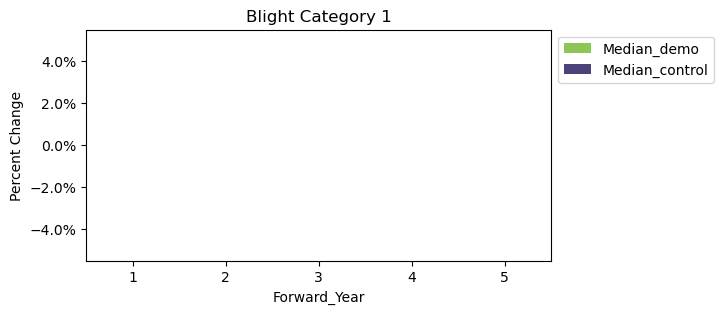

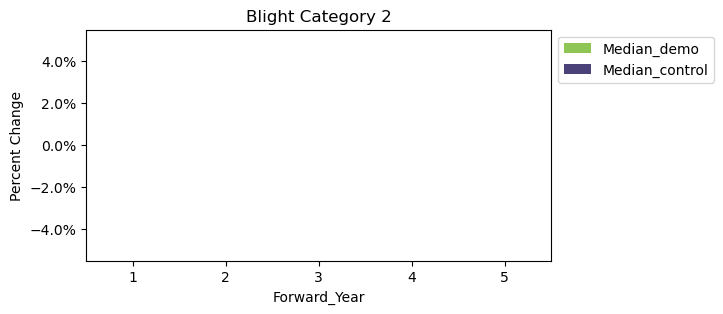

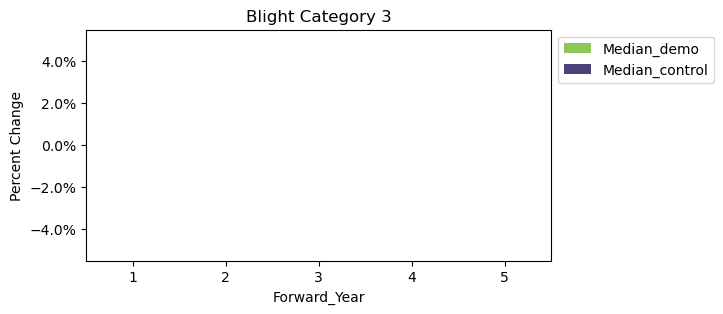

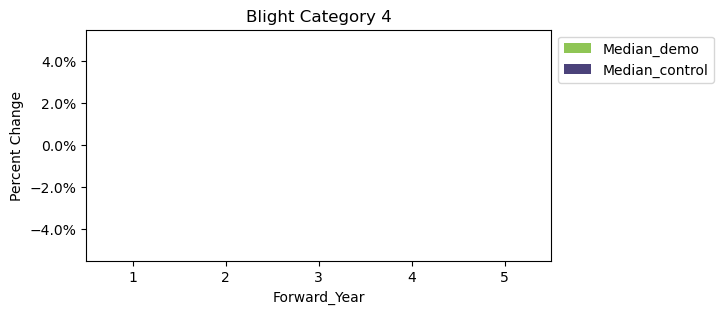

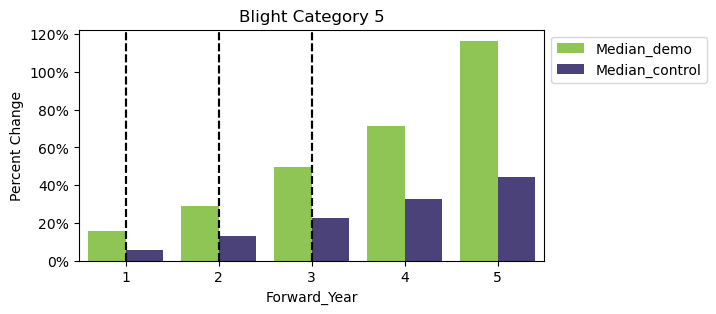

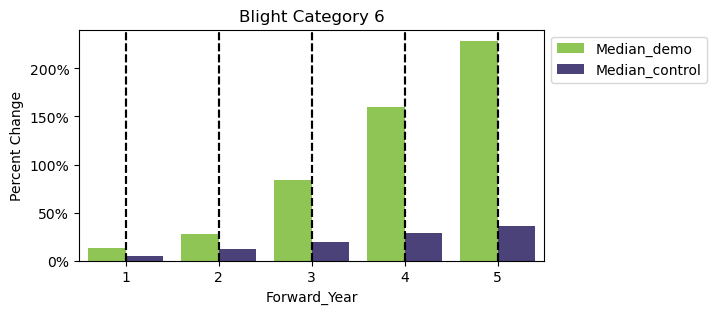

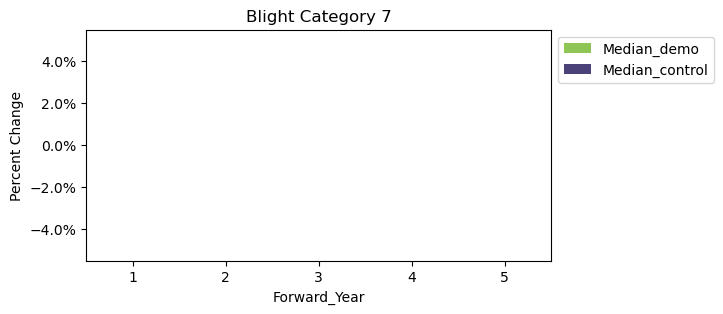

In [86]:
cmap = {
    'Median_demo': '#90d743',
    'Median_control': '#443983'
}

for i in ['1', '2', '3', '4', '5', '6', '7']:
    toPlot = (
        summary_table_pct
        .loc[summary_table_pct['Blight_Cluster'] == i]
        .assign(Forward_Year = ['1', '2', '3', '4', '5'])
        [['Forward_Year', 'Median_demo', 'Median_control']]
        .melt(
            id_vars = 'Forward_Year'
        )
        .rename(columns = {'variable': 'Group', 'value': 'Percent Change'})
        .merge(
            right = summary_table_pct.loc[summary_table_pct['Blight_Cluster'] == i].assign(Forward_Year = ['1', '2', '3', '4', '5'])[['Forward_Year', 'p_value']],
            on = 'Forward_Year', how = 'left'
        )
    )

    plt.figure(figsize = (6, 3))
    sns.barplot(toPlot, x = 'Forward_Year', y = 'Percent Change', hue = 'Group', palette = cmap)
    signifs = toPlot.loc[toPlot['p_value'] < 0.01]['Forward_Year'].values
    for s in signifs:
        plt.axvline(x = s, color = 'black', linestyle = '--')
    plt.title(f'Blight Category {i}')
    plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

In [29]:
summary_table_pct.query('p_value < 0.01').sort_values(by = ['Blight_Cluster', 'Pct_Delta'])

,Blight_Cluster,Pct_Delta,n_demo,n_control,Median_demo,Median_control,p_value,demo_to_control
3,4,pct_delta_1,244,194280,0.0425,0.0528,0.0012,0.8053
10,4,pct_delta_2,214,155424,0.0860,0.1181,0.0011,0.7284
17,4,pct_delta_3,164,116568,0.1481,0.1759,0.0017,0.8419
24,4,pct_delta_4,91,77712,0.2218,0.2520,0.0052,0.8802
31,4,pct_delta_5,52,38856,0.2864,0.3200,0.0033,0.8952
25,5,pct_delta_4,91,63034,0.3649,0.2970,0.0090,1.2287
5,6,pct_delta_1,163,60010,0.0924,0.0618,0.0002,1.4952
33,6,pct_delta_5,37,12002,0.2295,0.5382,0.0000,0.4263


<Axes: xlabel='Pct_Delta', ylabel='Blight_Cluster'>

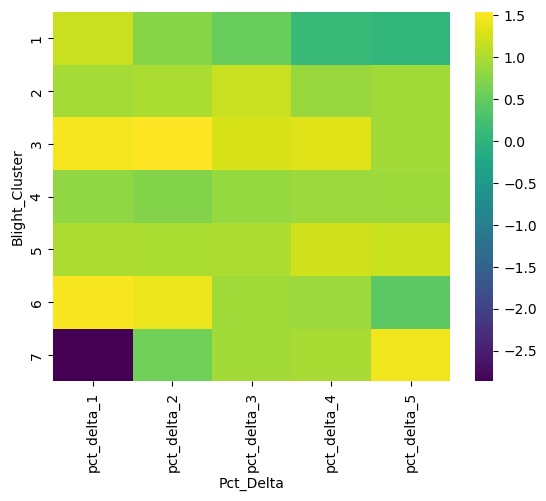

In [36]:
sns.heatmap(summary_table_pct.pivot(
    index = 'Blight_Cluster', columns = 'Pct_Delta', values = 'demo_to_control'
), cmap = 'viridis')

In [38]:
summary_table_pct.pivot(
    index = 'Blight_Cluster', columns = 'Pct_Delta', values = 'demo_to_control'
)

Pct_Delta,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5
Blight_Cluster,,,,,
1,1.1756,0.7419,0.5321,0.1076,0.0160
2,0.9444,0.9852,1.1780,0.8652,0.9090
3,1.4806,1.5411,1.2762,1.3276,0.9358
4,0.8053,0.7284,0.8419,0.8802,0.8952
5,1.0022,0.9747,0.9951,1.2287,1.1836
6,1.4952,1.4100,0.9081,0.8701,0.4263
7,-2.8667,0.5853,0.9335,0.9568,1.4473


In [ ]:
for c in demos['blight'].unique():
    sample = parcels.loc[parcels['year'] >= 2020]
    sub = sample.loc[sample['blight'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(sub[['cagr_1', 'cagr_2', 'cagr_3', 'cagr_4', 'cagr_5']].median())
    print('n:', n)
    print('\n')

In [ ]:
for c in demos['blight'].unique():
    sample = demos.loc[demos['demo_year'] == demos['year']]
    sub = sample.loc[sample['blight'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(sub[['cagr_1', 'cagr_2', 'cagr_3', 'cagr_4', 'cagr_5']].median())
    print('n:', n)
    print('\n')